In [2]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway

petersburg = [0.0974, 0.1352, 0.0817, 0.1016, 0.0968, 0.1064, 0.105]
magadan = [0.1033, 0.0915, 0.0781, 0.0685, 0.0677, 0.0697, 0.0764,
           0.0689]

In [3]:
df=pd.concat([pd.DataFrame({'city':'petersburg', 'data': petersburg}), pd.DataFrame({'city':'magadan', 'data': magadan})], axis=0)

In [4]:
alpha = 0.05

H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

In [5]:
from scipy.stats import shapiro
_, p = shapiro(df[df.city=='petersburg']['data'])
print('p=%.3f' % p)
if p > alpha:
	print(H0)
else:
	print(Ha)
_, p = shapiro(df[df.city=='magadan']['data'])
print('p=%.3f' % p)
if p > alpha:
	print(H0)
else:
	print(Ha)

p=0.242
Данные распределены нормально
p=0.036
Данные не распределены нормально (мы отвергаем H0)


Посмотрим на графики qq-plot

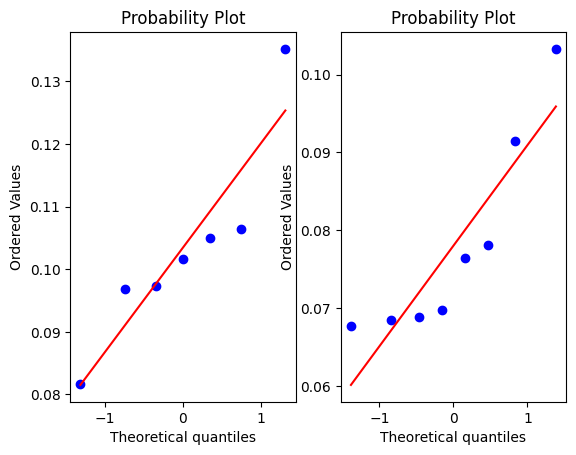

In [6]:
import matplotlib.pyplot as plt # библиотека визуализации
from scipy import stats # библиотека для расчетов

plt.subplot(1, 2, 1) # задаем сетку рисунка количество строк и столбцов
stats.probplot(df[df.city=='petersburg']['data'], plot=plt); # qq plot

plt.subplot(1, 2, 2) # располагаем второй рисунок рядом
stats.probplot(df[df.city=='magadan']['data'], plot=plt); # qq plot

Возможно, я как-то неверно поняла задание, но сама идея проведения корреляционного теста в случае, когда наши выборки имеют разное кол-во наблюдений и не являются наблюдениями связанными через какое-то конкретное событие кажется достаточно странной идеей, не совсем ясно какая точка  из набора данных Магадана должна сооветствовать точке из набора данных Петербурга. 
Т.е. если бы данные наблюдения были как-то упорядочены через какой-то параметр в виде, например, месяца наблюдения, то мы могли бы сопоставить наблюдения между собой и проверить корреляцию.
С учетом имеющихся наборов и исходных даннные, единственное, что я могу сделать, это сопоставить наблюдения просто исходя из первоночального порядка и оставить равное кол-во наблюдений в 2х выборках min(len(petersburg), len(magadan))
Давайте посмотрим, что нам покажет тест Шапиро-Уилко, если мы в данных по Магадану исключим последнее наблюдение  

In [7]:
_, p = shapiro(df[df.city=='magadan']['data'][:7])
print('p=%.3f' % p)
if p > alpha:
	print(H0)
else:
	print(Ha)

p=0.133
Данные распределены нормально


Т.о. с усеченными данными по Магадану тест на корреляцию мы можем проводить и методом Пирсона

In [8]:
df_=pd.DataFrame({'petersburg':petersburg, 'magadan':magadan[:7]})

In [9]:
df_.corr()

,petersburg,magadan
petersburg,1.000000,0.255095
magadan,0.255095,1.000000


Исходя из полученного коэффициента мы можем говорить об отсутсвии связи

Для сравнения среднего размера мидий по городам мы бы могли применить критерий Манна-Уитни, но для его применения у нас должны быть выборки одного размера.
Когда мы исключаем крайнее наблюдение в наборе данных по Магадану, то получаем нормальное распределение, при нормальном распределении можно использовать и критерий T-Cтьюдента.
Но насколько это корректно - не понятно
Поэтому воспорльзуюсь методом бутстрапа (буду извлекать подвыборки с возвращением многократное ко-во раз)

H0=средние размеры раковин мидий равны в городах
H1=средние размеры раковин отличны

In [10]:
plt.style.use('ggplot')
from tqdm.auto import tqdm
from scipy.stats import norm

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 2000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('blue')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

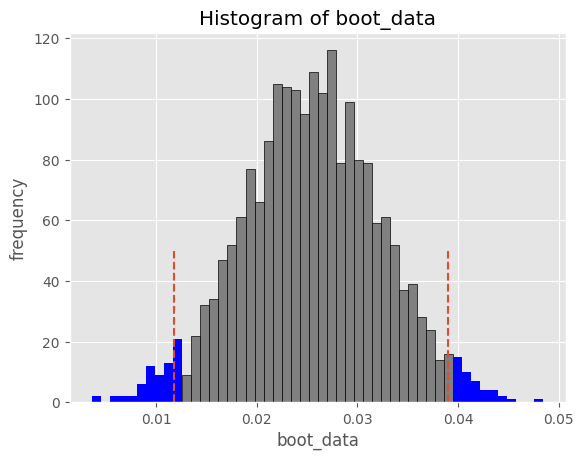

In [11]:
booted = get_bootstrap(df[df.city=='petersburg']['data'], df[df.city=='magadan']['data'])

In [12]:
booted['p_value']

0.00017124267174783208

p-value<0.05, различия статистически значимые, отклоняем нулевую гипотезу

In [13]:
p_mean=df[df.city=='petersburg']['data'].mean()
m_mean=df[df.city=='magadan']['data'].mean()
display(p_mean,m_mean,p_mean/m_mean )

0.10344285714285714

0.0780125

1.3259779797193674

Размер раковин статистически значимо больше в городе Санкт-Петербурге на 33%.
